In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd

# from brats.utils import show_mri

In [5]:
INPUT_ADNI_DIR = Path('/data/slow/ADNI')

img_fpaths = list(INPUT_ADNI_DIR.glob('**/*.nii'))
len(img_fpaths)

2767

In [7]:
OUTPUT_ADNI_DIR = Path('/data/slow/ADNI_prep')

len(list(OUTPUT_ADNI_DIR.glob('*.nii')))

2764

76 images were discarded.

In [17]:
missing_imgs_fpaths = list()
n_imgs_fpaths = dict()
for img_fpath in img_fpaths:
    local_fpath = str(img_fpath).lstrip(str(INPUT_ADNI_DIR))
    subject_id = local_fpath.split('/')[0]

    image_id = img_fpath.name.split('_')[-1][:-4]
    
    img_fname = f"{subject_id}__{image_id}__*.nii"
    if len(list(OUTPUT_ADNI_DIR.glob(img_fname))) < 1:
        missing_imgs_fpaths.append(img_fpath)
    
    if not img_fname in n_imgs_fpaths.keys():
        n_imgs_fpaths[img_fname] = 1
    else:
        n_imgs_fpaths[img_fname] += 1

len(missing_imgs_fpaths)

73

In [18]:
multi_imgs = [k for k,v in n_imgs_fpaths.items() if v > 1]
multi_imgs

['094_S_1241__I41449__*.nii',
 '094_S_1241__I70013__*.nii',
 '006_S_4485__I1051710__*.nii']

In [19]:
i = 0

In [44]:
img_fpath = missing_imgs_fpaths[i]

print(i)
print(img_fpath)

i += 1

show_mri(img_fpath)

8
/data/slow/ADNI/168_S_6049/Accelerated_Sagittal_MPRAGE/2020-10-12_13_11_29.0/S966259/ADNI_168_S_6049_MR_Accelerated_Sagittal_MPRAGE__br_raw_20201012165108296_102_S966259_I1348108.nii


OSError: Expected 25559040 bytes, got 3014304 bytes from /data/slow/ADNI/168_S_6049/Accelerated_Sagittal_MPRAGE/2020-10-12_13_11_29.0/S966259/ADNI_168_S_6049_MR_Accelerated_Sagittal_MPRAGE__br_raw_20201012165108296_102_S966259_I1348108.nii
 - could the file be damaged?

In [46]:
nib.load(img_fpath).get_fdata()

OSError: Expected 25559040 bytes, got 3014304 bytes from /data/slow/ADNI/168_S_6049/Accelerated_Sagittal_MPRAGE/2020-10-12_13_11_29.0/S966259/ADNI_168_S_6049_MR_Accelerated_Sagittal_MPRAGE__br_raw_20201012165108296_102_S966259_I1348108.nii
 - could the file be damaged?

files damaged:

- 0: /data/slow/ADNI/094_S_1241/MP-RAGE/2008-05-08_13_49_43.0/S50440/ADNI_094_S_1241_MR_MP-RAGE__br_raw_20080521101110638_1_S50440_I106320.nii
- 1: /data/slow/ADNI/100_S_0069/Sagittal_3D_Accelerated_MPRAGE/2019-01-23_13_17_50.0/S787747/ADNI_100_S_0069_MR_Sagittal_3D_Accelerated_MPRAGE_br_raw_20190124004844579_1_S787747_I1119606.nii
- 3: /data/slow/ADNI/002_S_4262/MPRAGE/2012-01-02_13_27_48.0/S135052/ADNI_002_S_4262_MR_MPRAGE_br_raw_20120103095051041_19_S135052_I274823.nii
- 4: /data/slow/ADNI/137_S_0972/MP-RAGE/2008-12-02_15_06_48.0/S60444/ADNI_137_S_0972_MR_MP-RAGE__br_raw_20081203083427360_1_S60444_I129029.nii
- 6: /data/slow/ADNI/007_S_1222/MP-RAGE/2008-02-22_08_51_18.0/S46098/ADNI_007_S_1222_MR_MP-RAGE__br_raw_20080223113756555_1_S46098_I91633.nii
- 7: /data/slow/ADNI/022_S_4266/MPRAGE/2012-03-06_13_16_45.0/S143253/ADNI_022_S_4266_MR_MPRAGE_br_raw_20120308154812534_159_S143253_I289098.nii


/data/slow/ADNI/027_S_0403/MPRAGE/2008-05-12_10_10_59.0/S49902/ADNI_027_S_0403_MR_MPRAGE_br_raw_20080512112713319_1_S49902_I105096.nii
crop not possible with crop (1.0, 1.0, 1.0) and img shape (160, 240, 256, 1)


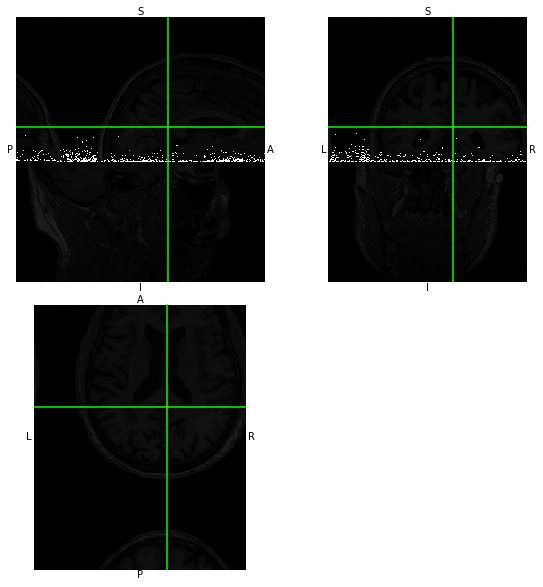

In [29]:
print('/data/slow/ADNI/027_S_0403/MPRAGE/2008-05-12_10_10_59.0/S49902/ADNI_027_S_0403_MR_MPRAGE_br_raw_20080512112713319_1_S49902_I105096.nii')
show_mri('/data/slow/ADNI/027_S_0403/MPRAGE/2008-05-12_10_10_59.0/S49902/ADNI_027_S_0403_MR_MPRAGE_br_raw_20080512112713319_1_S49902_I105096.nii', pos=(2*120,2*147,1.35*427))

crop not possible with crop (1.0, 1.0, 1.0) and img shape (39, 256, 256, 1)


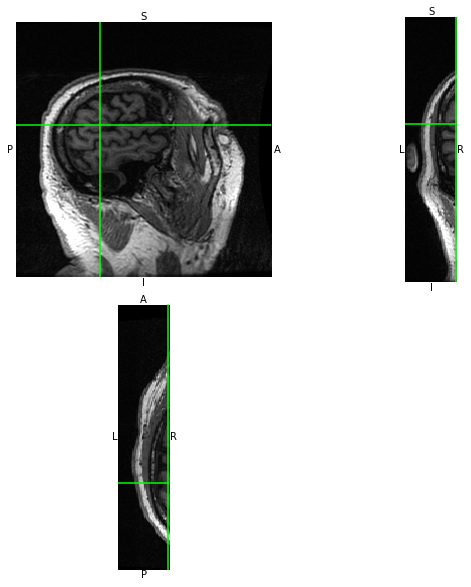

In [41]:
show_mri('/data/slow/ADNI/027_S_0118/MP-RAGE/2009-02-10_10_18_52.0/S62838/ADNI_027_S_0118_MR_MP-RAGE__br_raw_20090210151033568_3_S62838_I135611.nii', pos=(2*55,1.5*158,1.35*408))

In [26]:
imgs_fpaths = {s.name: list(s.glob('**/*.nii*')) for s in subs_dirs}
imgs_fpaths

{'127_S_0260': [PosixPath('/data/slow/ADNI/127_S_0260/MP-RAGE/2007-05-08_13_08_10.0/S31931/ADNI_127_S_0260_MR_MP-RAGE__br_raw_20070508182015932_1_S31931_I53879.nii')],
 '131_S_1301': [PosixPath('/data/slow/ADNI/131_S_1301/MP-RAGE/2009-03-06_11_48_33.0/S64051/ADNI_131_S_1301_MR_MP-RAGE__br_raw_20090306135904502_1_S64051_I137874.nii'),
  PosixPath('/data/slow/ADNI/131_S_1301/MP-RAGE/2007-10-02_07_32_34.0/S40835/ADNI_131_S_1301_MR_MP-RAGE__br_raw_20071002135530603_166_S40835_I76478.nii')],
 '014_S_4080': [PosixPath('/data/slow/ADNI/014_S_4080/MPRAGE/2011-09-15_10_36_02.0/S122218/ADNI_014_S_4080_MR_MPRAGE_br_raw_20110919080459703_165_S122218_I256293.nii'),
  PosixPath('/data/slow/ADNI/014_S_4080/MPRAGE/2011-06-16_10_23_25.0/S111770/ADNI_014_S_4080_MR_MPRAGE_br_raw_20110616134213033_147_S111770_I240491.nii')],
 '029_S_0866': [PosixPath('/data/slow/ADNI/029_S_0866/MP-RAGE/2009-10-27_14_03_51.0/S75772/ADNI_029_S_0866_MR_MP-RAGE__br_raw_20091030144749097_84_S75772_I158102.nii')],
 '024_S_1063'

/tmp/ipykernel_778938/46363474.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  img_fpath = np.random.choice(list(imgs_fpaths.values()))[-1]


(166, 256, 256, 1)
[[  1.19999874   0.           0.         119.53099823]
 [  0.           0.9375       0.         159.78019714]
 [  0.           0.           0.9375     405.23901367]
 [  0.           0.           0.           1.        ]]


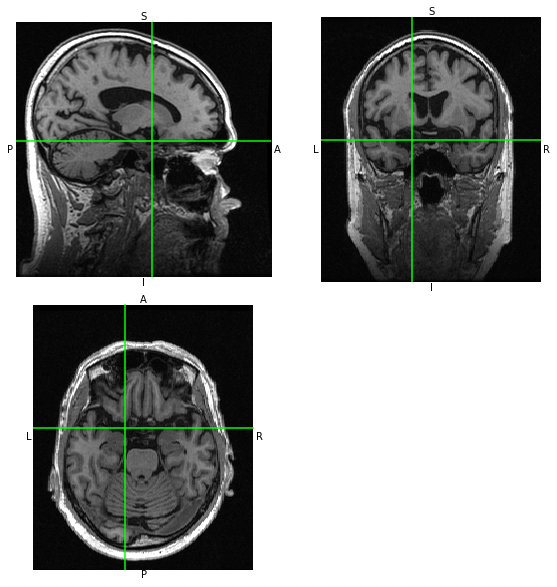

In [93]:
img_fpath = np.random.choice(list(imgs_fpaths.values()))[-1]

img = nib.load(img_fpath)

print(img.shape)
print(img.affine)
show_mri(img, pos=tuple(img.affine[:3,3] + np.array(img.shape)[:-1] / 2))

In [94]:
img_fpath

PosixPath('/data/slow/ADNI/014_S_0519/MP-RAGE/2013-05-08_14_59_36.0/S188967/ADNI_014_S_0519_MR_MP-RAGE__br_raw_20130509105103646_95_S188967_I371705.nii')

In [3]:
import pandas as pd

pd.read_csv('~/data/ADNI/META_ADNI_T1.csv')

,Unnamed: 0,mr_id,filename,patient,age
0,0,I238627,/home/jupyter/data/ADNI/ADNI_preprocessed/regi...,002_S_0295_1,90
1,1,I303066,/home/jupyter/data/ADNI/ADNI_preprocessed/regi...,002_S_0295_2,91
2,2,I144447,/home/jupyter/data/ADNI/ADNI_preprocessed/regi...,002_S_0295_3,88
3,3,I13722,/home/jupyter/data/ADNI/ADNI_preprocessed/regi...,002_S_0295_4,85
4,4,I173732,/home/jupyter/data/ADNI/ADNI_preprocessed/regi...,002_S_0295_5,89
...,...,...,...,...,...
2728,2728,I1046736,/home/jupyter/data/ADNI/ADNI_preprocessed/regi...,941_S_6580_1,80
2729,2729,I1343715,/home/jupyter/data/ADNI/ADNI_preprocessed/regi...,941_S_6580_2,82
2730,2730,I1226810,/home/jupyter/data/ADNI/ADNI_preprocessed/regi...,941_S_6580_3,81
2731,2731,I1343754,/home/jupyter/data/ADNI/ADNI_preprocessed/regi...,941_S_6581_1,76


In [193]:
import pandas as pd

df = pd.read_csv(next(Path('/data/slow/ADNI').glob('*.csv')))
df.head()

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I1048378,941_S_6581,CN,F,74,1,MRI,Accelerated Sagittal MPRAGE,Original,9/12/2018,DCM,4/12/2022
1,I1343754,941_S_6581,CN,F,76,103,MRI,Accelerated Sagittal MPRAGE,Original,9/25/2020,DCM,4/12/2022
2,I1226810,941_S_6580,CN,F,81,102,MRI,Accelerated Sagittal MPRAGE,Original,9/13/2019,DCM,4/13/2022
3,I1343715,941_S_6580,CN,F,82,103,MRI,Accelerated Sagittal MPRAGE,Original,9/28/2020,DCM,4/12/2022
4,I1046736,941_S_6580,CN,F,80,1,MRI,Accelerated Sagittal MPRAGE,Original,9/07/2018,DCM,4/12/2022


In [131]:
s = df.sample().iloc[0]

s

Image Data ID       I277125
Subject          100_S_0069
Group                    CN
Sex                       M
Age                      79
Visit                    26
Modality                MRI
Description      ASO-MPRAGE
Type               Original
Acq Date          1/09/2012
Format                  DCM
Downloaded        4/12/2022
Name: 881, dtype: object

In [132]:
list(Path('/data/slow/ADNI').glob(f"{s['Subject']}/**/{s['Image Data ID']}"))

[]

In [133]:
list(Path('/data/slow/ADNI').glob(f"{s['Subject']}/*"))

[PosixPath('/data/slow/ADNI/100_S_0069/ASO-MPRAGE')]

In [127]:
002_S_6007

'002_S_6007'

In [126]:
list(Path('/data/slow/ADNI').glob(f"*"))

[PosixPath('/data/slow/ADNI/127_S_0260'),
 PosixPath('/data/slow/ADNI/023_S_0963'),
 PosixPath('/data/slow/ADNI/016_S_0538'),
 PosixPath('/data/slow/ADNI/131_S_1301'),
 PosixPath('/data/slow/ADNI/005_S_0223'),
 PosixPath('/data/slow/ADNI/002_S_0295'),
 PosixPath('/data/slow/ADNI/014_S_4080'),
 PosixPath('/data/slow/ADNI/131_S_0319'),
 PosixPath('/data/slow/ADNI/029_S_0866'),
 PosixPath('/data/slow/ADNI/024_S_1063'),
 PosixPath('/data/slow/ADNI/082_S_1256'),
 PosixPath('/data/slow/ADNI/007_S_6255'),
 PosixPath('/data/slow/ADNI/037_S_0467'),
 PosixPath('/data/slow/ADNI/094_S_1241'),
 PosixPath('/data/slow/ADNI/100_S_0069'),
 PosixPath('/data/slow/ADNI/126_S_0605'),
 PosixPath('/data/slow/ADNI/130_S_6372'),
 PosixPath('/data/slow/ADNI/037_S_0327'),
 PosixPath('/data/slow/ADNI/094_S_0711'),
 PosixPath('/data/slow/ADNI/136_S_4269'),
 PosixPath('/data/slow/ADNI/057_S_0818'),
 PosixPath('/data/slow/ADNI/100_S_0035'),
 PosixPath('/data/slow/ADNI/068_S_0210'),
 PosixPath('/data/slow/ADNI/109_S_

In [135]:
!ls /data/slow/ADNI/100_S_0069/ASO-MPRAGE/2009-03-18_14_40_03.0/

I139562


In [145]:
f = np.random.choice(list(Path('/data/slow/ADNI').glob('**/*.nii')))
f

PosixPath('/data/slow/ADNI/941_S_1195/Accelerated_Sagittal_MPRAGE/2020-08-31_12_39_49.0/S954865/ADNI_941_S_1195_MR_Accelerated_Sagittal_MPRAGE__br_raw_20200901111904544_42_S954865_I1332317.nii')

In [159]:
sid = str(f).split('/')[4]
iid = str(f).split('/')[-2]
sid, iid

('941_S_1195', 'S954865')

In [160]:
df[df['Subject'] == sid]

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
95,I673911,941_S_1195,CN,M,86,34,MRI,MPRAGE,Original,3/04/2016,DCM,4/12/2022
96,I362292,941_S_1195,CN,M,83,28,MRI,MPRAGE,Original,3/07/2013,DCM,4/13/2022
97,I167111,941_S_1195,CN,M,80,8,MRI,MPRAGE,Original,2/27/2010,DCM,4/12/2022
98,I1332317,941_S_1195,CN,M,91,103,MRI,Accelerated Sagittal MPRAGE,Original,8/31/2020,DCM,4/12/2022
99,I223980,941_S_1195,CN,M,81,10,MRI,MPRAGE,Original,3/15/2011,DCM,4/12/2022
100,I982345,941_S_1195,CN,M,88,101,MRI,Accelerated Sagittal MPRAGE,Original,4/05/2018,DCM,4/12/2022
101,I81801,941_S_1195,CN,M,78,3,MRI,MPRAGE,Original,11/11/2007,DCM,4/12/2022
102,I420205,941_S_1195,CN,M,84,30,MRI,MPRAGE,Original,4/15/2014,DCM,4/12/2022
103,I291410,941_S_1195,CN,M,82,26,MRI,MPRAGE,Original,3/21/2012,DCM,4/12/2022
104,I137022,941_S_1195,CN,M,79,6,MRI,MPRAGE,Original,2/24/2009,DCM,4/12/2022


In [164]:
iids = [f.name.split('_')[-1][:-4] for f in Path('/data/slow/ADNI').glob('**/*.nii')]
all([iid in df['Image Data ID'].values for iid in iids])

True

Found a way to get the ages!

# Preprocessing

In [2]:
from brats.preprocessing.nipype_wrappers import ants_registration, ants_transformation

img_fpath = np.random.choice(list(Path('/data/slow/ADNI').glob('**/*.nii')))

img = nib.load(img_fpath)

show_mri(img, pos=tuple(img.affine[:3,3] + np.array(img.shape)[:-1] / 2))

220418-13:22:55,268 nipype.utils WARNING:
	 A newer version (1.7.1) of nipy/nipype is available. You are using 1.6.0


NameError: name 'show_mri' is not defined

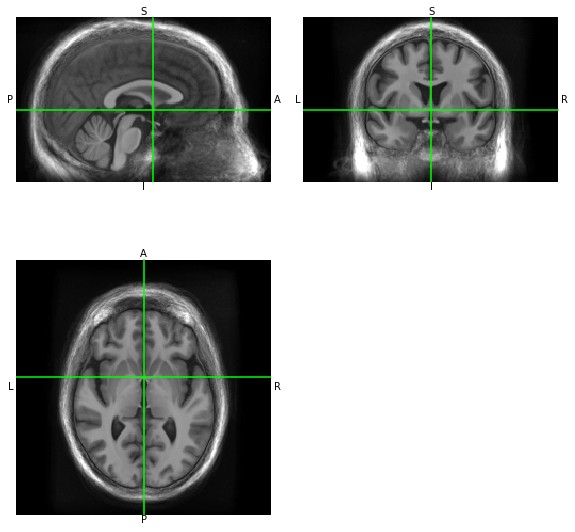

In [177]:
template_fpath = Path('../data/external/SRI24_T1.nii')

show_mri(template_fpath, pos=(0,0,0))

In [179]:
reg_transform, _ = ants_registration(template_fpath, img_fpath, '.tmpdir/reg_')
reg_transform

'/home/bruno-pacheco/brain-age/notebooks/.tmpdir/reg_0GenericAffine.mat'

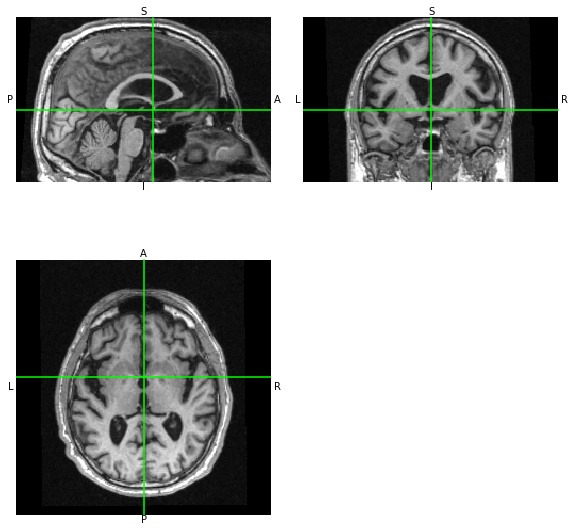

In [183]:
sri_img_fpath = ants_transformation(img_fpath, template_fpath, [reg_transform,], '.tmpdir/sri24_')

show_mri(sri_img_fpath, pos=(0,0,0))

In [197]:
local_fpath = str(img_fpath).lstrip(str(Path('/data/slow/ADNI')))
subject_id = local_fpath.split('/')[0]

image_id = img_fpath.name.split('_')[-1][:-4]

In [198]:
subject_id, image_id

('035_S_0156', 'I89963')

In [202]:
df[(df['Subject'] == subject_id) & (df['Image Data ID'] == image_id)].iloc[0]

Image Data ID        I89963
Subject          035_S_0156
Group                    CN
Sex                       M
Age                      76
Visit                     6
Modality                MRI
Description          MPRAGE
Type               Original
Acq Date          2/07/2008
Format                  DCM
Downloaded        4/12/2022
Name: 1559, dtype: object

# Preprocessed data

In [223]:
!ls ../data/raw/ADNI_prep

002_S_0295__I114210__87.nii   041_S_0125__I135066__77.nii
002_S_0295__I13722__85.nii    041_S_0125__I167380__78.nii
002_S_0295__I144446__88.nii   041_S_0125__I20211__74.nii
002_S_0295__I144447__88.nii   041_S_0125__I37809__75.nii
002_S_0295__I173732__89.nii   041_S_0125__I37810__75.nii
002_S_0295__I238627__90.nii   041_S_0125__I89019__76.nii
002_S_0295__I28561__85.nii    041_S_0125__I9924__74.nii
002_S_0295__I303066__91.nii   041_S_0262__I101894__88.nii
002_S_0295__I55275__86.nii    041_S_0262__I12137__86.nii
002_S_0413__I114997__79.nii   041_S_0262__I12139__86.nii
002_S_0413__I1221051__90.nii  041_S_0262__I142333__89.nii
002_S_0413__I143221__79.nii   041_S_0262__I170756__90.nii
002_S_0413__I14437__76.nii    041_S_0262__I170762__90.nii
002_S_0413__I173460__80.nii   041_S_0262__I35070__87.nii
002_S_0413__I240812__82.nii   041_S_0262__I52148__87.nii
002_S_0413__I29705__77.nii    041_S_0898__I132134__85.nii
002_S_0413__I304793__82.nii   041_S_0898__I158501__86.nii
002_S_0413__I371991__83.

(240, 240, 155)
[[   1.    0.   -0. -120.]
 [   0.    1.   -0. -129.]
 [   0.    0.    1.  -68.]
 [   0.    0.    0.    1.]]


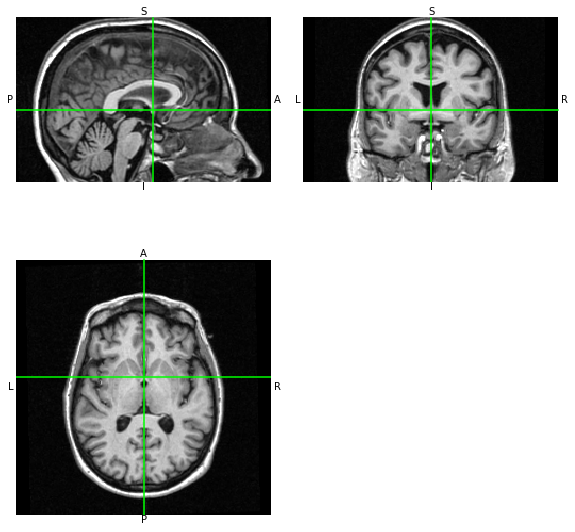

In [5]:
img_fpath = np.random.choice(list(Path('/data/slow/ADNI_prep').glob('*.nii')))

img = nib.load(img_fpath)

print(img.shape)
print(img.affine)
show_mri(img, pos=(0,0,0))

(1, 80, 192, 160)


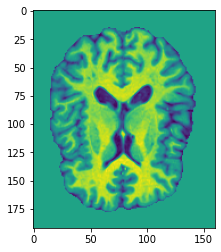

In [52]:
from collections import OrderedDict
from nnunet.preprocessing.preprocessing import PreprocessorFor2D
from batchgenerators.augmentations.utils import pad_nd_image
from brats.preprocessing.hdbet_wrapper import hd_bet

def load_preprocess_for_nnunet(
        img_fpath,
        tmpdir='.tmpdir',
        patch_size=[192, 160],
        input_shape_must_be_divisible_by=[32, 32],
        normalization_schemes=OrderedDict([(0, 'nonCT')]),
        use_mask_for_norm=OrderedDict([(0, True)]),
        transpose_forward=[0, 1, 2],
        intensity_properties=None,
        target_spacing=[1., 1., 1.],
    ):
    brain_img_fpath, _ = hd_bet(img_fpath, tmpdir, mode='fast')

    prep = PreprocessorFor2D(normalization_schemes, use_mask_for_norm,
                                transpose_forward, intensity_properties)
    brain, _, prop = prep.preprocess_test_case([str(brain_img_fpath),], target_spacing)

    # get only slices with meaningful brain info
    crop_lb = prop['crop_bbox'][0][0]
    lb = 35 - crop_lb
    ub = 115 - crop_lb
    brain = brain[:,lb:ub]

    padded_brain, _ = pad_nd_image(
        brain,
        patch_size,
        mode='constant',
        kwargs={'constant_values': 0},
        return_slicer=True,
        shape_must_be_divisible_by=input_shape_must_be_divisible_by,
    )

    return padded_brain

prep_img = load_preprocess_for_nnunet(img_fpath)

print(prep_img.shape)
plt.imshow(prep_img[0,40])

# Split

In [9]:
df = pd.read_csv('dataframe2D-ADNI.csv', index_col=0)
df.head()

,patient,filename,slice,age,dataset,split
0,ADNI_010_S_0419,/home/jupyter/data/ADNI/slices/010_S_0419_10_s...,25,70,ADNI,val
1,ADNI_010_S_0419,/home/jupyter/data/ADNI/slices/010_S_0419_10_s...,26,70,ADNI,val
2,ADNI_010_S_0419,/home/jupyter/data/ADNI/slices/010_S_0419_10_s...,27,70,ADNI,val
3,ADNI_010_S_0419,/home/jupyter/data/ADNI/slices/010_S_0419_10_s...,28,70,ADNI,val
4,ADNI_010_S_0419,/home/jupyter/data/ADNI/slices/010_S_0419_10_s...,29,70,ADNI,val


In [10]:
df.groupby('patient')['split'].first()

patient
ADNI_002_S_0295    train
ADNI_002_S_0413    train
ADNI_002_S_0559    train
ADNI_002_S_0685    train
ADNI_002_S_1261    train
                   ...  
ADNI_941_S_6570    train
ADNI_941_S_6574    train
ADNI_941_S_6575      val
ADNI_941_S_6580    train
ADNI_941_S_6581    train
Name: split, Length: 663, dtype: object

In [5]:
df['split'].value_counts()

train    88400
val      20400
Name: split, dtype: int64

In [62]:
train_sids = df[df['split'] == 'train']['patient'].unique()
train_sids

array(['ADNI_130_S_0886', 'ADNI_007_S_6455', 'ADNI_941_S_6580',
       'ADNI_035_S_6730', 'ADNI_130_S_6027', 'ADNI_941_S_6058',
       'ADNI_082_S_4208', 'ADNI_051_S_1123', 'ADNI_003_S_6259',
       'ADNI_006_S_4150', 'ADNI_032_S_4348', 'ADNI_022_S_0014',
       'ADNI_013_S_6780', 'ADNI_114_S_6063', 'ADNI_114_S_6309',
       'ADNI_032_S_4304', 'ADNI_130_S_0232', 'ADNI_073_S_4552',
       'ADNI_068_S_4174', 'ADNI_131_S_6692', 'ADNI_011_S_0008',
       'ADNI_013_S_1276', 'ADNI_082_S_6283', 'ADNI_009_S_0842',
       'ADNI_032_S_6211', 'ADNI_941_S_1203', 'ADNI_100_S_4511',
       'ADNI_114_S_0601', 'ADNI_141_S_1094', 'ADNI_012_S_4642',
       'ADNI_168_S_6492', 'ADNI_032_S_6701', 'ADNI_031_S_4032',
       'ADNI_135_S_4566', 'ADNI_100_S_1286', 'ADNI_052_S_1251',
       'ADNI_041_S_6447', 'ADNI_033_S_6572', 'ADNI_022_S_4320',
       'ADNI_116_S_6750', 'ADNI_082_S_4339', 'ADNI_109_S_6218',
       'ADNI_168_S_6059', 'ADNI_023_S_0963', 'ADNI_073_S_4762',
       'ADNI_094_S_6485', 'ADNI_014_S_40

In [63]:
val_sids = df[df['split'] == 'val']['patient'].unique()
val_sids

array(['ADNI_010_S_0419', 'ADNI_141_S_0726', 'ADNI_130_S_6391',
       'ADNI_137_S_0283', 'ADNI_035_S_6751', 'ADNI_016_S_0359',
       'ADNI_032_S_6294', 'ADNI_018_S_6351', 'ADNI_082_S_6415',
       'ADNI_023_S_6346', 'ADNI_021_S_0647', 'ADNI_023_S_1190',
       'ADNI_128_S_0229', 'ADNI_021_S_0159', 'ADNI_168_S_6285',
       'ADNI_013_S_0502', 'ADNI_114_S_6524', 'ADNI_007_S_6120',
       'ADNI_003_S_6260', 'ADNI_003_S_4644', 'ADNI_007_S_0070',
       'ADNI_099_S_0534', 'ADNI_036_S_6316', 'ADNI_002_S_6009',
       'ADNI_033_S_4179', 'ADNI_072_S_4103', 'ADNI_094_S_0526',
       'ADNI_031_S_0618', 'ADNI_006_S_0484', 'ADNI_023_S_1306',
       'ADNI_036_S_6466', 'ADNI_035_S_4464', 'ADNI_032_S_6717',
       'ADNI_116_S_6517', 'ADNI_023_S_6270', 'ADNI_131_S_0436',
       'ADNI_116_S_6458', 'ADNI_099_S_0040', 'ADNI_036_S_0672',
       'ADNI_137_S_6826', 'ADNI_094_S_6440', 'ADNI_006_S_0681',
       'ADNI_130_S_6111', 'ADNI_941_S_6254', 'ADNI_099_S_4076',
       'ADNI_082_S_6563', 'ADNI_052_S_09

In [71]:
imgs_dir = Path('../data/raw/ADNI_prep')

imgs_fpaths = list(imgs_dir.glob('*.nii'))

len(imgs_fpaths)

2727

In [100]:
train_fpaths_ = [list(imgs_dir.glob(f"{sid[5:]}*.nii")) for sid in train_sids]
train_fpaths = list()
for fs in train_fpaths_:
    train_fpaths += fs

val_fpaths = list(set(imgs_fpaths).difference(set(train_fpaths)))

assert len(val_fpaths) + len(train_fpaths) == len(imgs_fpaths)

len(train_fpaths) / len(imgs_fpaths)

0.8085808580858086

In [101]:
val_fpaths

[PosixPath('../data/raw/ADNI_prep/127_S_0259__I47591__72.nii'),
 PosixPath('../data/raw/ADNI_prep/032_S_1169__I949029__83.nii'),
 PosixPath('../data/raw/ADNI_prep/003_S_6092__I944379__65.nii'),
 PosixPath('../data/raw/ADNI_prep/006_S_0484__I47327__72.nii'),
 PosixPath('../data/raw/ADNI_prep/127_S_0259__I99698__73.nii'),
 PosixPath('../data/raw/ADNI_prep/114_S_0173__I41856__74.nii'),
 PosixPath('../data/raw/ADNI_prep/009_S_4612__I424035__71.nii'),
 PosixPath('../data/raw/ADNI_prep/131_S_0441__I103961__75.nii'),
 PosixPath('../data/raw/ADNI_prep/029_S_0843__I24406__71.nii'),
 PosixPath('../data/raw/ADNI_prep/035_S_0555__I213220__81.nii'),
 PosixPath('../data/raw/ADNI_prep/114_S_0166__I90738__75.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_4213__I573758__82.nii'),
 PosixPath('../data/raw/ADNI_prep/141_S_6416__I1018186__69.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_4225__I297357__71.nii'),
 PosixPath('../data/raw/ADNI_prep/035_S_0156__I497588__84.nii'),
 PosixPath('../data/raw/ADNI_p

In [105]:
val_sids_csv = set([sid[5:] for sid in val_sids])

assert len(val_sids_csv) == len(val_sids)

val_sids_split = set([fp.name.split('__')[0] for fp in val_fpaths])

assert len(val_sids_split) == len(val_sids_csv)
assert len(val_sids_split.intersection(val_sids_csv)) == len(val_sids_csv)

AssertionError: 

In [106]:
len(val_sids_split)

132

In [107]:
len(val_sids_csv)

129

In [108]:
val_sids_split.difference(val_sids_csv)

{'011_S_6714', '035_S_6739', '041_S_0262', '141_S_6178'}

In [109]:
val_sids_csv.difference(val_sids_split)

{'003_S_6257'}

In [149]:
sorted(train_fpaths)

[PosixPath('../data/raw/ADNI_prep/002_S_0295__I114210__87.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_0295__I13722__85.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_0295__I144446__88.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_0295__I144447__88.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_0295__I173732__89.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_0295__I238627__90.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_0295__I28561__85.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_0295__I303066__91.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_0295__I55275__86.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_0413__I114997__79.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_0413__I1221051__90.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_0413__I143221__79.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_0413__I14437__76.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_0413__I173460__80.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_0413__I240812__82.nii'),
 PosixPath('../data/raw/ADNI

In [150]:
train_fpaths

[PosixPath('../data/raw/ADNI_prep/130_S_0886__I119619__73.nii'),
 PosixPath('../data/raw/ADNI_prep/130_S_0886__I77144__72.nii'),
 PosixPath('../data/raw/ADNI_prep/130_S_0886__I267862__77.nii'),
 PosixPath('../data/raw/ADNI_prep/130_S_0886__I48660__72.nii'),
 PosixPath('../data/raw/ADNI_prep/130_S_0886__I25455__71.nii'),
 PosixPath('../data/raw/ADNI_prep/007_S_6455__I1011962__68.nii'),
 PosixPath('../data/raw/ADNI_prep/007_S_6455__I1344288__70.nii'),
 PosixPath('../data/raw/ADNI_prep/941_S_6580__I1343715__82.nii'),
 PosixPath('../data/raw/ADNI_prep/941_S_6580__I1226810__81.nii'),
 PosixPath('../data/raw/ADNI_prep/941_S_6580__I1046736__80.nii'),
 PosixPath('../data/raw/ADNI_prep/035_S_6730__I1176653__74.nii'),
 PosixPath('../data/raw/ADNI_prep/130_S_6027__I1254168__78.nii'),
 PosixPath('../data/raw/ADNI_prep/130_S_6027__I938631__76.nii'),
 PosixPath('../data/raw/ADNI_prep/941_S_6058__I1209877__70.nii'),
 PosixPath('../data/raw/ADNI_prep/941_S_6058__I884964__68.nii'),
 PosixPath('../data/

# HDF5 Dataset

In [219]:
import h5py

with h5py.File('testfile.hdf5', 'w') as f:
    train = f.create_group('train')
    X = train.create_dataset('X', (80,192,160), maxshape=(None,192,160), dtype='float32', chunks=(1,192,160))
    y = train.create_dataset('y', (80,), maxshape=(None,), dtype='uint8')

    X[0:80] = prep_img[0]
    y[0:80] = 71

with h5py.File('testfile.hdf5', 'r+') as f:
    X = f['/train/X']
    y = f['/train/y']
    print(X.shape)
    print(y.shape)
    X.resize(X.shape[0]+80, axis=0)
    y.resize(y.shape[0]+80, axis=0)

    X[80:] = prep_img[0]*-1
    y[80:] = 70
    print(X.shape)
    print(y.shape)

(80, 192, 160)
(80,)
(160, 192, 160)
(160,)


In [220]:
with h5py.File('testfile.hdf5', 'r') as f:
    X = f['/train/X']
    y = f['train']['y']
    i0 = X[0]
    y0 = y[0]
    i1 = X[80]
    y1 = y[80]

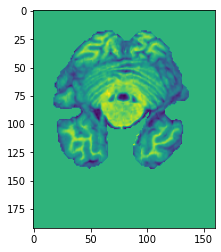

In [208]:
plt.imshow(i0)

In [221]:
y0

71

In [222]:
y1

70

In [218]:
int(img_fpath.name.split('.')[0].split('__')[-1])

71

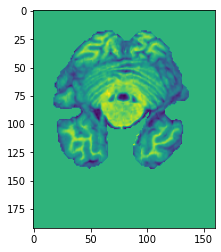

In [209]:
plt.imshow(-1*i1)

In [184]:
with h5py.File('/home/bruno-pacheco/brain-age/data/interim/ADNI_slices.hdf5', 'r+') as h:
    dset = h['test']
    print(dset.shape)
    data = dset[:]

(480, 192, 160)


In [277]:
with h5py.File('/home/bruno-pacheco/brain-age/data/interim/ADNI_slices.hdf5', 'r') as h:
    print(h['train']['y'].shape)

(160,)


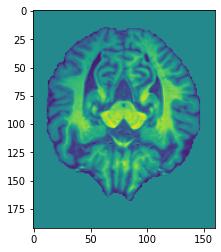

In [196]:
plt.imshow(data[np.random.choice(np.arange(480))])

In [223]:
h = h5py.File('/home/bruno-pacheco/brain-age/data/interim/ADNI_slices.hdf5', 'r')
h.close()

<HDF5 file "ADNI_slices.hdf5" (mode r)>

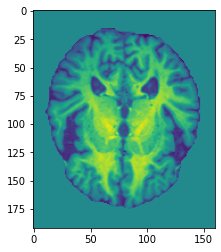

In [234]:
plt.imshow(h['test']['X'][np.random.choice(880)])

In [256]:
h['test']['y'][-2]

0

In [265]:
prep_img[0].shape == (80, 192, 160)

True

In [266]:
img_fpath.unlink

<bound method Path.unlink of PosixPath('/data/slow/ADNI_prep/128_S_0272__I12313__71.nii')>

In [274]:
!ls /home/bruno-pacheco/brain-age/data/raw/ADNI_prep/137_S_6826__I1242424__68.nii

/home/bruno-pacheco/brain-age/data/raw/ADNI_prep/137_S_6826__I1242424__68.nii


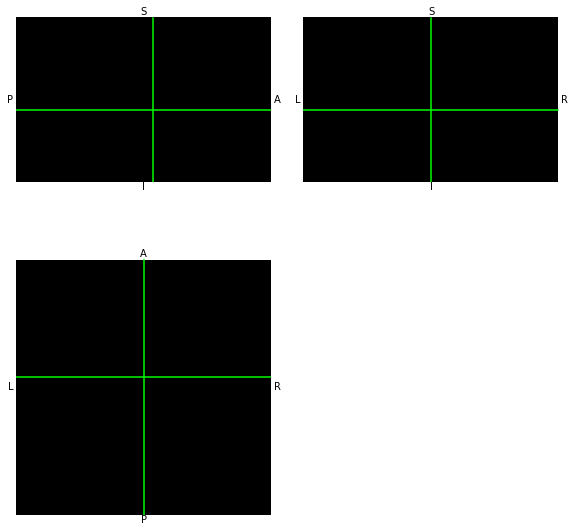

In [292]:
show_mri('/home/bruno-pacheco/brain-age/data/raw/ADNI_prep/168_S_6049__I1348108__76.nii', pos=(0,0,0))

In [332]:
h = h5py.File('/home/bruno-pacheco/brain-age/data/interim/ADNI_slices.hdf5', 'r')

In [295]:
h.keys()

<KeysViewHDF5 ['test', 'train']>

In [310]:
X_train = h['train/X']

X_train[np.random.choice(X_train.shape[0])].shape

(192, 160)

In [348]:
torch.Tensor([h['train/y'][25]])

tensor([76.])

In [349]:
h.close()

In [53]:
import h5py
from torch.utils.data import Dataset
import torch
from torchvision import transforms

class ADNIDatasetForBraTSModel(Dataset):
    def __init__(
        self,
        hdf5_fpath,
        transform=transforms.ToTensor(),
        dataset='train',
    ) -> None:
        super().__init__()

        hdf5_fpath = Path(hdf5_fpath)
        assert hdf5_fpath.exists()

        self._fpath = hdf5_fpath
        self.dataset = dataset

        self.transform = transform

    def __len__(self):
        with h5py.File(self._fpath, 'r') as h:
            l = h[self.dataset]['y'].shape[0]

        return l

    def __getitem__(self, index: int):
        with h5py.File(self._fpath, 'r') as h:
            img = h[self.dataset]['X'][index]
            label = h[self.dataset]['y'][index]

        label = torch.Tensor([label])
        label = label.view(label.shape[0], 1)

        # transform
        if self.transform:
            img = self.transform(img)

        return img, label

ds = ADNIDatasetForBraTSModel('/home/bruno-pacheco/brain-age/data/interim/ADNI_slices_fix_2mm_split.hdf5', dataset='train')
len(ds) / 40

1606.0

In [101]:
torch.rand(20,20).median()

tensor(0.5189)

In [51]:
ds = ADNIDatasetForBraTSModel('/home/bruno-pacheco/brain-age/data/interim/ADNI_slices_fix_2mm_split.hdf5', dataset='test')
len(ds) / 40

584.0

In [92]:
ds = ADNIDatasetForBraTSModel('/home/bruno-pacheco/brain-age/data/interim/ADNI_slices_fix_2mm_split.hdf5', dataset='val')
len(ds) / 40

561.0

In [14]:
pd.read_csv('dataframe3D.csv', index_col=0)['split'].value_counts()

train    1593
test      586
val       554
Name: split, dtype: int64

tensor([[86.]])


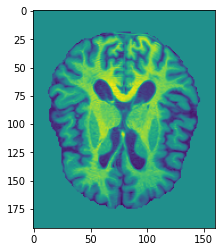

In [325]:
x, y = ds[42]

print(y)
plt.imshow(x.detach().numpy().squeeze())
plt.show()

In [331]:
torch.Tensor(12)

tensor([1.6160e+10, 4.5820e-41, 7.4249e+28, 3.0624e-41, 4.4842e-44, 0.0000e+00,
        8.9683e-44, 0.0000e+00, 7.0398e+25, 3.0624e-41, 2.5223e-44, 0.0000e+00])

In [350]:
ds[500]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([[82.]]))